# Import librairy

In [3]:
!pip install xgboost

     |████████████████████████████████| 192.9 MB 8.6 kB/s s eta 0:00:01█▌                 | 87.3 MB 23.8 MB/s eta 0:00:05ta 0:00:01


In [4]:
import time # to measure time

import pandas as pd # CPU

import xgboost as xgb # model

from tqdm import tqdm # to display progress bar

# CPU
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing


# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from xgboost import plot_importance, plot_tree
from sklearn.utils import resample

#qiskit
import numpy as np
import math

from sklearn.svm import *
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.decomposition import *

from qiskit import *
from qiskit.circuit.library import *
from qiskit.utils import *
from qiskit_machine_learning.algorithms import *
from qiskit_machine_learning.kernels import *
from qiskit_machine_learning.datasets import *
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
import timeit

# defining some metrics and the data set
seed = 1234

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Load data

In [19]:
%%time

# CPU
X_train = pd.read_csv("train_reduced.csv")
X_test = pd.read_csv("test_reduced.csv")
Y_test = pd.read_csv("Y_test_reduced.csv")
Y_train = pd.read_csv("Y_train_reduced.csv")

CPU times: user 6.14 ms, sys: 334 µs, total: 6.47 ms
Wall time: 52.6 ms


In [20]:
print(f'Training dataset has {X_train.shape[0]} observations and {X_train.shape[1]} features.')
print(f'Test dataset has {X_test.shape[0]} observations and {X_test.shape[1]} features.')

Training dataset has 160 observations and 5 features.
Test dataset has 40 observations and 5 features.


In [23]:
# get ratio of positive cases (1) to negative cases (0)
ratio_of_positive = Y_train.sum()/(len(Y_train)-Y_train.sum())
print(round(ratio_of_positive,3), ": 1 ratio of positive:negative")

isFraud    1.0
dtype: float64 : 1 ratio of positive:negative


# Train model

In [24]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    tree_method="hist",
    # scale up the weight of positive samples
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric="auc"
)

#xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, 
                         #learning_rate=0.1, n_estimators=100, eval_metric="auc")
#xgbc.fit(Xtr, np.ravel(Ytr))
#submission["isFraud"] = xgbc.predict_proba(Xte)[:, 1]

In [25]:
# CPU
train_start_time = time.time()

model.fit(X_train, np.ravel(Y_train),verbose=False)

train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 0 seconds


# Prediction

In [26]:
%%time

# CPU
preds = model.predict(X_train)

CPU times: user 7.77 ms, sys: 0 ns, total: 7.77 ms
Wall time: 6.19 ms


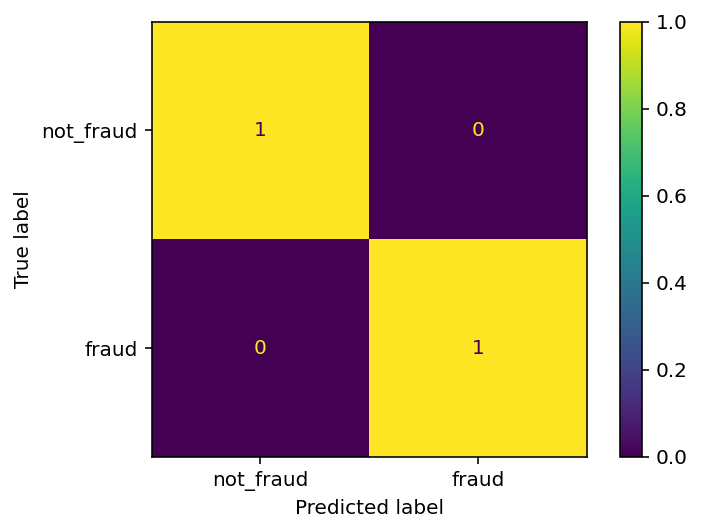

In [27]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_train, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

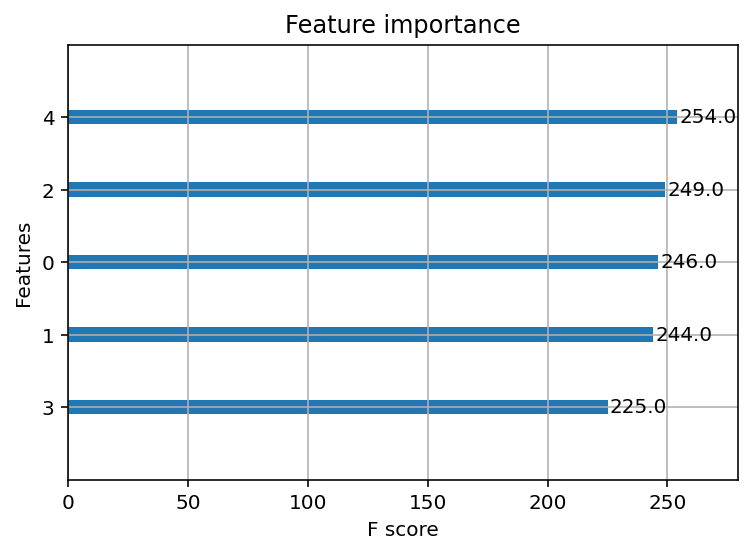

In [28]:
plot_importance(model, max_num_features=10)
plt.show()

In [29]:
print("Accuracy of Model on training set::",model.score(X_train,Y_train))

Accuracy of Model on training set:: 1.0


# Result on test data

In [30]:
preds = model.predict(X_test)

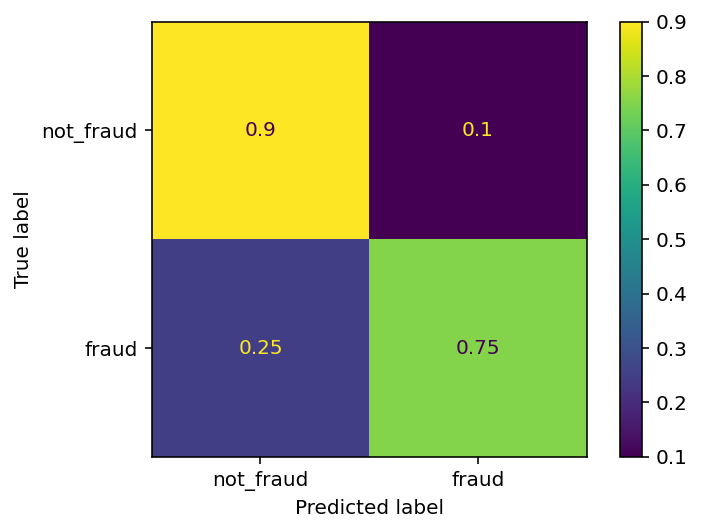

In [31]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [32]:
print("Accuracy of Model on training set::",model.score(X_test,Y_test))

Accuracy of Model on training set:: 0.825


# Quantum approach

In [33]:
def QSVM(dimension, reps,X_reduced, Y_reduced, X_test,Y_test, precomputedKernel=False,seed=seed,shots=1024):
    # defining the backend
    print("define backend")
    start = time.time()
    ad_hoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=shots,
                                seed_simulator=seed, seed_transpiler=seed)
    end = time.time()
    print("time : ",abs(end-start))
    
    print("define feature map")
    start = time.time()
    # in this excercice we will only test for ZZfeatureMap, the input will be the number of reps
    ad_hoc_feature_map = ZZFeatureMap(feature_dimension=dimension,
                                 reps=reps, entanglement='full')
    end = time.time()
    print("time : ",abs(end-start))
    
    print("define kernel map")
    start = time.time()
    # defining the kernel
    adhoc_kernel = QuantumKernel(feature_map=ad_hoc_feature_map, quantum_instance=ad_hoc_backend)
    end = time.time()
    print("time : ",abs(end-start))
    
    
    if precomputedKernel:
        print("evaluate on train")
        start = time.time()
        adhoc_matrix_train= adhoc_kernel.evaluate(x_vec=X_reduced)
        end = time.time()
        print("time : ",abs(end-start))
        
        print("build kernel")
        start = time.time()
        engine =QSVC(kernel="precomputed")
        end = timeit.timeit()
        print("time : ",abs(end-start))
        
        print("calibrate")
        start = time.time()
        engine.fit(adhoc_matrix_train, Y_reduced)
        end = time.time()
        print("time : ",abs(end-start))
        
        print("score")
        start = time.time()
        score_train=  engine.score(adhoc_matrix_train,Y_reduced)
        end = time.time()
        print("time : ",abs(end-start))
    else:
        print("build engine")
        start = time.time()
        engine = QSVC(quantum_kernel=adhoc_kernel)
        end = time.time()
        print("time : ",end-start)
        
        # fitting the data
        print("calibrate")
        start = time.time()
        engine.fit(X_reduced, Y_reduced)
        end = time.time()
        print("time : ",end-start)
        
        print("score")
        start = time.time()
        score_train = engine.score(X_reduced, Y_reduced)
        end = time.time()
        print("time : ",end-start)
        
    print("score test")
    start = time.time()
    score_test = engine.score(X_test,Y_test)
    end = time.time()
    print("time : ",end-start)
    print("score train: ",score_train)
    print("score test: ",score_test)
    # looking at the score of the trainning data
    return engine

In [ ]:
engine= QSVM(dimension=5,reps=1,X_reduced=X_train, Y_reduced=np.ravel(Y_train), X_test=X_test,Y_test=Y_test)

define backend
time :  0.00015020370483398438
define feature map
time :  0.00037169456481933594
define kernel map
time :  0.00043702125549316406
build engine
time :  5.078315734863281e-05
calibrate
time :  143.06384778022766
score


In [246]:
X_train.to_csv("train_reduced.csv")


In [84]:
score_train

0.7166666666666667

In [ ]:
# CPU
# confusion matrix
cm = confusion_matrix(Y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [397]:
print("define backend")
ad_hoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
print("define feature map")
# in this excercice we will only test for ZZfeatureMap, the input will be the number of reps
ad_hoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=1, entanglement='full')
print("define kernel map")
# defining the kernel
adhoc_kernel = QuantumKernel(feature_map=ad_hoc_feature_map, quantum_instance=ad_hoc_backend)

define backend
define feature map
define kernel map


In [399]:
print("process data")
X_le_pca,X_te_pca = encode_normalize(X_train,X_test)
X_le_pca,X_te_pca = applyPCA(2,X_le_pca,X_te_pca)
X_reduced, Y_reduced = reduce(X_le_pca,Y_train,25)

process data
start encoding
start normalization
the explained variance for the train test is [36.48580001 30.17117549], which is 66.65697550460558%
the explained variance for the test is [36.41338078 13.18244569], which is 49.59582646812329%
copy data
group data
split data


In [400]:
engine = QSVC(quantum_kernel=adhoc_kernel)
# fitting the data
print("calibrate")
engine.fit(X_reduced, Y_reduced)
print("score")
score_train = engine.score(X_reduced, Y_reduced)

calibrate
score


In [406]:
print(f"score train",score_train)
prediction =engine.predict(X_te_pca)

score train 0.78


KeyboardInterrupt: 

# VQC

In [128]:
print("define backend")
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,seed_simulator=seed, seed_transpiler=seed)
print("define OpFlowQNN")
opflow_qnn = TwoLayerQNN(num_qubits = 2, quantum_instance=quantum_instance)
print("define the callback function : did not build to be consider later on")
callback_graph = None
print("define NN classifer")
opflow_classifer = NeuralNetworkClassifier(opflow_qnn,optimizer=COBYLA(),callback = callback_graph)
print("define PCA for train")
pcatrain = PCA(n_components  =2)
train_features = pcatrain.fit_transform(X_train)
print("define PCA for test")
pcatest = PCA(n_components  =2)
test_features = pcatest.fit_transform(X_valid)
print("train the model")
opflow_classifer.fit(train_features,y_train.values)


define backend
define OpFlowQNN
define the callback function : did not build to be consider later on
define NN classifer
define PCA for train
define PCA for test
train the model


KeyboardInterrupt: 

In [ ]:
print("score on training set")
opflow_classifier.score(X_train,y_train)
print("score on validation set")
opflow_classifier.score(X_test,y_test)

# QNN

In [127]:
print("contruct feature map")
feature_map = ZZFeatureMap(2)
print("construct ansatz")
ansatz = RealAmplitudes(2,reps=1)
print("cosntruct circuit")
qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))
qc.decompose().draw(output="mpl")

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#comment from the session :
#better cleaning of the data : and then resampling
# resampling the dataset : 200 transactions : 100/100
# PCA increase : test 2, 3, 4, 5 
#need to check the explanability 

In [131]:
pcatrain = PCA(n_components  =5)
train_features = pcatrain.fit_transform(X_train)
print(pcatrain.explained_variance_ratio_)

[9.99300425e-01 5.44551561e-04 1.41077626e-04 1.03462923e-05
 1.12314824e-06]
